# Reading the rock property catalog

This notebook accompanies a blog post — [The Rock Property Catalog again](http://www.agilegeoscience.com/blog/2015/10/5/the-rock-property-catalog-again)

## Querying

This is very hacky. It will change. Stay tuned.

In [1]:
import requests
import pandas as pd

class RPC(object):
    def __init__(self):
        pass
    
    def _query_ssw(self, filters, properties, options):
        
        base_url = "http://www.subsurfwiki.org/api.php"
        q = "action=ask&query=[[RPC:%2B]]"
        q += ''.join(filters) if filters else ''
        q += '|%3F' + '|%3F'.join(properties) if properties else ''
        q += '|' + '|'.join(options) if options else ''
        q += '&format=json'
        
        return requests.get(base_url, params=q)
    
    def _get_formats(self, response):
        formats = {}
        for item in response.json()['query']['printrequests']:
            if item[u'mode'] == 1:
                formats[item[u'label']] = item[u'typeid'].lstrip('_')
        return formats
    
    def _build_dataframe(self, response):
        """
        Takes the response of a query and returns a pandas
        dataframe containing the results.
        """
        try:
            s = list(response.json()['query']['results'].keys())
        except Exception as e:
            raise e
        samples = [i[4:] for i in s]
        df = pd.DataFrame(samples)

        # We'll need to know the formats of the columns.
        formats = self._get_formats(response)
        properties = formats.keys()

        # Now traverse the JSON and build the DataFrame.
        for prop in properties:
            temp = []
            for row in list(s):
                p = response.json()['query']['results'][row]['printouts']
                if p[prop]:
                    if formats[prop] == 'qty':   # Quantity, number + unit
                        temp.append(p[prop][0]['value'])
                    elif formats[prop] == 'wpg':  # Wiki page
                        temp.append(p[prop][0]['fulltext'])
                    else:                         # Anything else: num, txt, tem, etc.
                        temp.append(p[prop][0])
                else:
                    temp.append(None)
            df[prop] = temp
        
        df = df.set_index(0)
        df.index.name = None

        return df
    
    def query(self, filters=None, properties=None, options=None):
        r = self._query_ssw(filters, properties, options)
        if r.status_code == 200:
            return self._build_dataframe(r)
        else:
            print("Something went wrong.")
        

In [3]:
rpc = RPC()

filters = ["[[lithology::Shale||Sandstone||Limestone]][[Delta::%2B]]"]
properties = ['Citation', 'Description', 'Lithology', 'Vp', 'Vs', 'Rho', 'Delta', 'Epsilon']
options = ["limit=100"]

df = rpc.query(filters, properties, options)
df.head()

,Delta,Lithology,Vp,Epsilon,Vs,Citation,Rho,Description
100015,0.6263,Shale,NaN,0.955311,NaN,"Sondergeld, 2011",None,Haynesville Shale 2
100072,0.1180,Shale,3774.891853,0.245000,2508.933067,"Wang, 2002",None,Hard shale
100010,0.7319,Shale,NaN,0.586081,NaN,"Sondergeld, 2011",None,Haynesville Shale 1
100051,0.0320,Shale,2464.704037,0.258000,1470.468283,"Wang, 2002",None,Shale
100077,0.0950,Shale,3792.983055,0.240000,2276.750803,"Wang, 2002",None,Hard shale


In [4]:
len(df)

100

## Plotting!

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

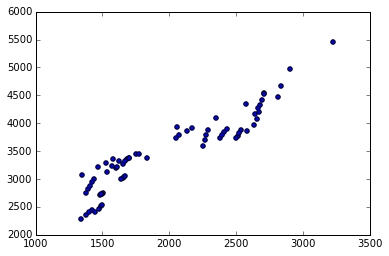

In [6]:
plt.scatter(df.Vs, df.Vp)

In [7]:
liths = df.groupby('Lithology')

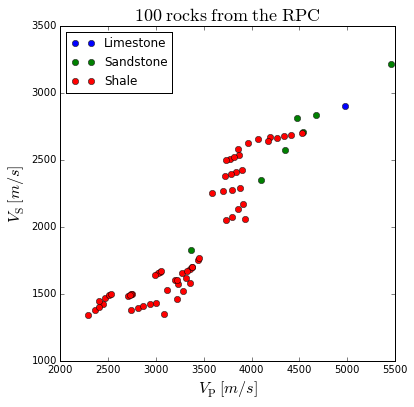

In [8]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for name, group in liths:
    ax.plot(group.Vp, group.Vs, marker='o', linestyle='', ms=6, label=name)
ax.legend(loc=2)

title = '{0}\ rocks\ from\ the\ RPC'.format(len(df))
plt.title('$\mathrm{' + title + '}$', size=18)
plt.xlabel('$V_\mathrm{P}\ [m/s]$', size=16)
plt.ylabel('$V_\mathrm{S}\ [m/s]$', size=16)
plt.show()

<hr />
<p style="color:gray;">© Agile Geoscience 2015. This notebook is licensed under the terms of <a href="https://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0</a>. Please use it!</p>